# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

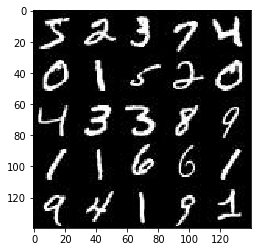

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

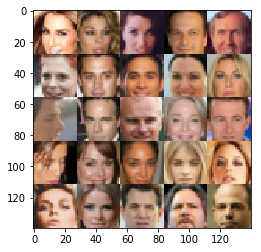

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/product/anaconda/envs/py36DeepUdacity/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = .1
    # kernel_initializer = tf.random_normal_initializer(stddev=5e-2)
    # Use of Xavier's weight initialization 
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    kernel_initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope('discriminator', reuse=reuse):
        # Shape of inputs: 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_initializer, padding='same')
        x = tf.maximum(x * alpha, x)
        # 14x14x64
    
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kernel_initializer, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
    
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kernel_initializer, padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        # Use dropout in the last layer of the discriminator to make it more robust
        x = tf.nn.dropout(x, 0.8)
        
        flat = tf.reshape(x, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = .1
    kernel_initializer = tf.random_normal_initializer(stddev=5e-2)
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7 * 7 * 256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kernel_initializer,
                                       padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kernel_initializer,
                                       padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64

        
        # Use dropout in the last layer of the generator to make it more robust
        x = tf.nn.dropout(x, 0.5)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1,
                                            kernel_initializer=kernel_initializer,
                                            padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = .2
    
    gen = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_out, d_fake_logits = discriminator(gen, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, x, y, c = data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, c)
    
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                # Train Model
                ii += 1
                # Normalizing inputs
                # More info for tips to train GANs at:
                # - https://www.youtube.com/watch?v=X1mUN6dD8uE
                # - https://github.com/soumith/ganhacks
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                # Train g_optim twice to make sure that d_loss does not go to zero
                # http://bamos.github.io/2016/08/09/deep-completion/
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if ii % 10 == 0: 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0: 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 4.0653
Epoch 1/2... Discriminator Loss: 2.2660... Generator Loss: 0.9243
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 4.7749
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 4.5871
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 5.3631
Epoch 1/2... Discriminator Loss: 0.3712... Generator Loss: 6.4320
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 5.4298
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 3.9600
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 3.1581
Epoch 1/2... Discriminator Loss: 0.4643... Generator Loss: 3.3089


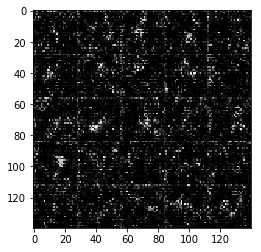

Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 6.9694... Generator Loss: 0.0097
Epoch 1/2... Discriminator Loss: 1.6680... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.8524
Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 4.8134
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 2.0247
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 3.1050
Epoch 1/2... Discriminator Loss: 1.6846... Generator Loss: 6.4442
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.7995


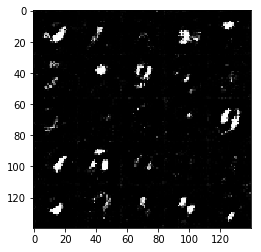

Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 2.9119
Epoch 1/2... Discriminator Loss: 1.7485... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 3.1223
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 2.9289
Epoch 1/2... Discriminator Loss: 0.4684... Generator Loss: 3.2973
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 2.6354
Epoch 1/2... Discriminator Loss: 3.3590... Generator Loss: 0.1593
Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 2.1797
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 2.4325
Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 3.0606


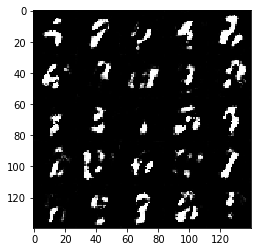

Epoch 1/2... Discriminator Loss: 0.5623... Generator Loss: 2.3379
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 3.3812
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.8922
Epoch 1/2... Discriminator Loss: 0.6486... Generator Loss: 1.8483
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 5.1794
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 2.1468
Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.6069
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.4600
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.1271


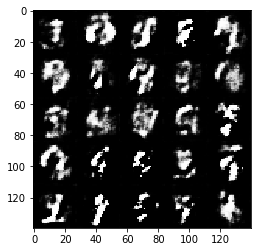

Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.5041
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 3.4159
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.8089
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 2.3445
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.9530
Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.8199
Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.4472
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.5281
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 3.2599
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 0.9248


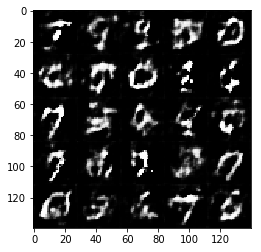

Epoch 1/2... Discriminator Loss: 0.8602... Generator Loss: 1.5798
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.3057
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 2.4735
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 1.5148
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 2.2929
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 2.1734
Epoch 1/2... Discriminator Loss: 1.8923... Generator Loss: 0.4279
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.6499


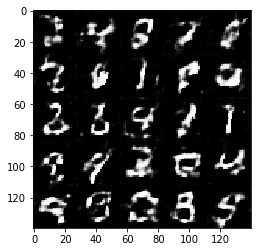

Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 1.9475
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 1.6230
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.5649
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.9608


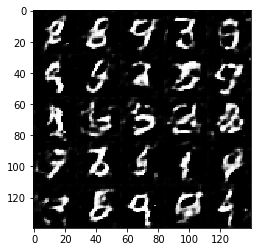

Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.1526
Epoch 1/2... Discriminator Loss: 0.7404... Generator Loss: 1.9049
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.2654
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.8589


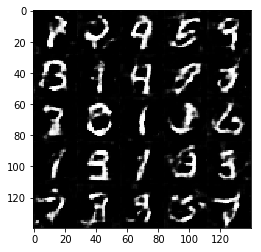

Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.9020
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.8021
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 2.3179
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 3.1751
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.4153


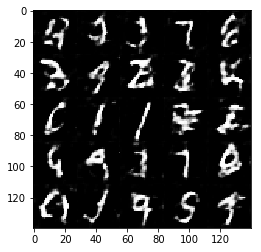

Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.3069
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.8961
Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.1924
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.2730
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.9074
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.5685
Epoch 2/2... Discriminator Loss: 1.6633... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 2.4789... Generator Loss: 0.3036


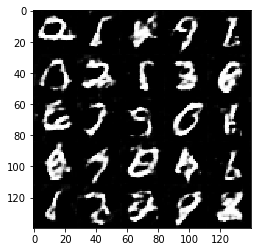

Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 2.2271
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.3041
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 2.0480
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 2.1071
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 1.9457... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.8051


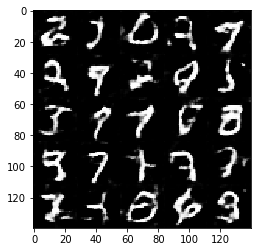

Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 1.8502... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 2.1466... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 1.2041


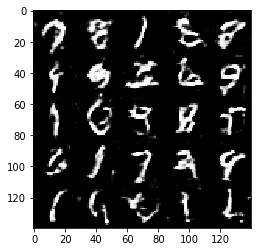

Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.7620
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.9061
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.4105
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.7703
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.0733
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.4598
Epoch 2/2... Discriminator Loss: 1.9172... Generator Loss: 0.4334


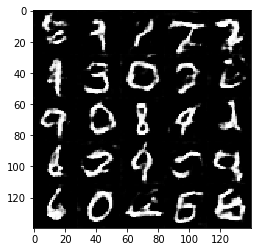

Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.8741
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.7336... Generator Loss: 0.4787
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.5741
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.0796


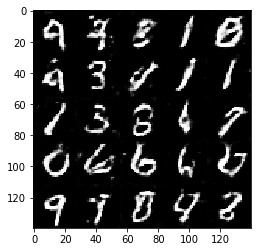

Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 2.2470
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.9369
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.8736
Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 2.1151
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1328
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.1864
Epoch 2/2... Discriminator Loss: 2.2724... Generator Loss: 0.3937
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.9072


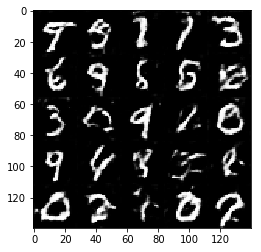

Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.5415
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 2.1748
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.5298
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.1958


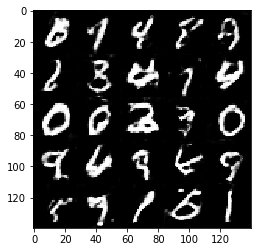

Epoch 2/2... Discriminator Loss: 2.2026... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 2.4252... Generator Loss: 0.3004
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 1.7134
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 1.9593
Epoch 2/2... Discriminator Loss: 2.1692... Generator Loss: 0.2479
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.3979
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.7657


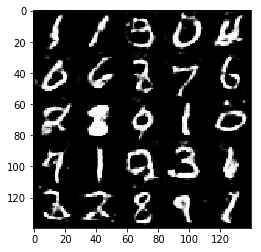

Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 2.2896... Generator Loss: 0.3837
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 2.1476... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.8350


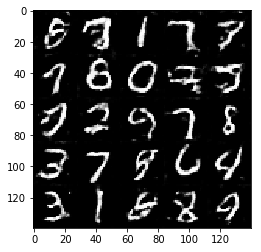

Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 2.0111... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 2.1691


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 2e-4
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 3.1166
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 3.5221
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 1.4882
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 3.5308
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 6.1727
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 5.2257
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.7190
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 3.1653
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 4.9715


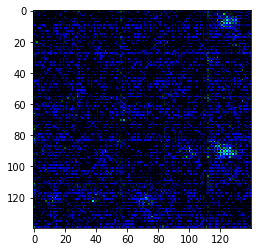

Epoch 1/1... Discriminator Loss: 3.3199... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 3.7718
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 4.1449
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.9875
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 4.0990
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 4.6093
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 5.6451
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 5.0743
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 5.4084
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 5.6337


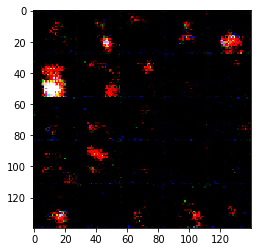

Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 5.7738
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 5.5051
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 5.7311
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 5.9261
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 5.9674
Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 5.4742
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 5.9541
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 6.0226
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 5.4837
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 5.7089


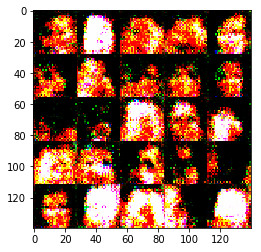

Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 5.6334
Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 5.8403
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 5.8968
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 7.0094
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 5.9047
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 6.2561
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 6.5022
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 6.2952
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 6.2899
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 7.9927


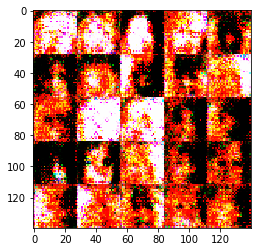

Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 6.2341
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 4.9245
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 5.3180
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 4.0675
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 3.3196
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 4.3589
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 4.5247
Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 3.4201
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.8191


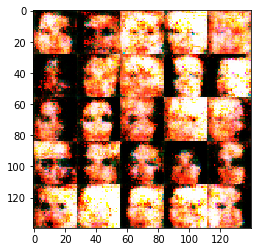

Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 4.6362
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.9471
Epoch 1/1... Discriminator Loss: 0.4303... Generator Loss: 4.1667
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.3497
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 2.0480
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 3.9374
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.2043
Epoch 1/1... Discriminator Loss: 1.6572... Generator Loss: 3.8821
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 2.9614


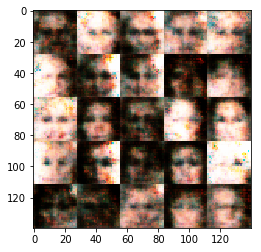

Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.9552
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 2.2330
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 2.1027


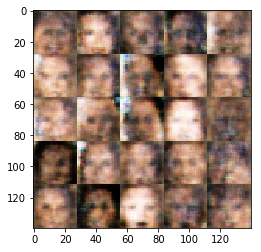

Epoch 1/1... Discriminator Loss: 2.4314... Generator Loss: 3.3656
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 2.5862
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.9903... Generator Loss: 3.9116
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 1.9945... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 2.1729... Generator Loss: 0.2058
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8194


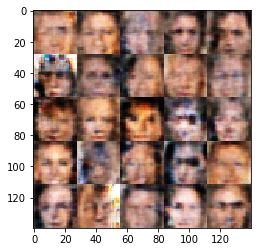

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 2.1458
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.2174


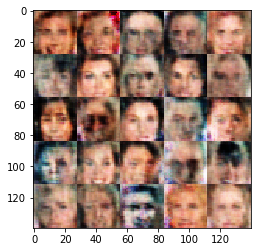

Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.5133


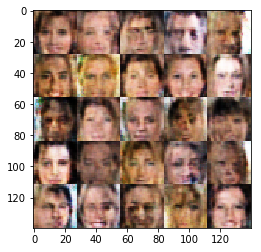

Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.6783


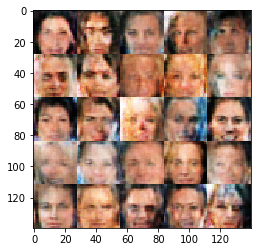

Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 2.2614
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7155


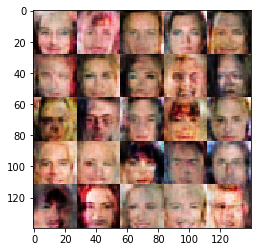

Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 1.8787
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.4881


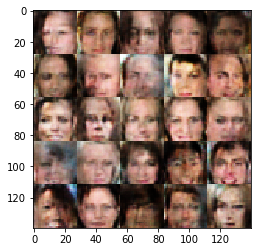

Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5756


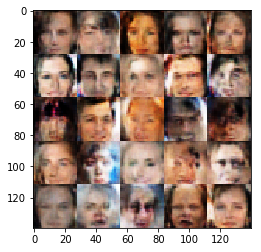

Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.3376
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.9009... Generator Loss: 0.3168
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.4216


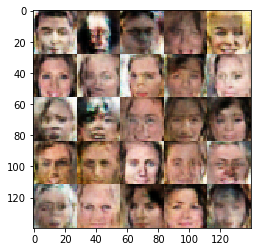

Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.3565
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5014


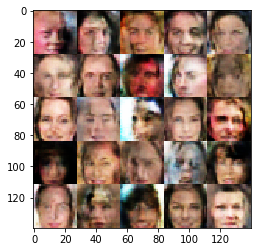

Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.9530... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.0507


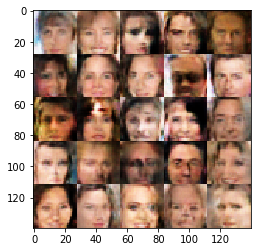

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.9990... Generator Loss: 0.2541


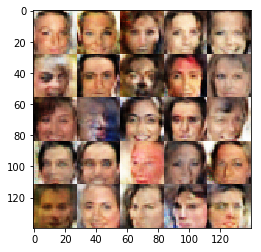

Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.8185... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.7302... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6858


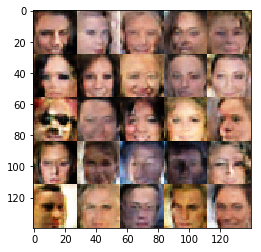

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.9244... Generator Loss: 0.2811
Epoch 1/1... Discriminator Loss: 1.7851... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.4929
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 2.1051... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.5306


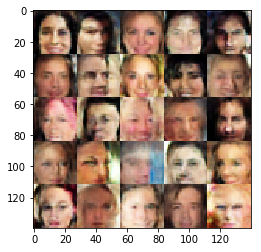

Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.8838... Generator Loss: 0.3706
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.9553... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.5984


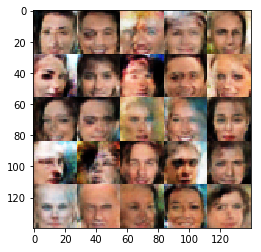

Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.3534
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6624


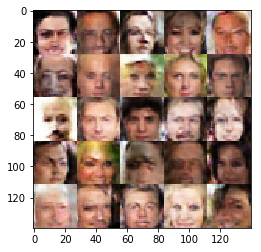

Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 2.1655... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.7354... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6946


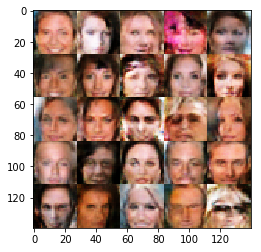

Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.8070... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.8655


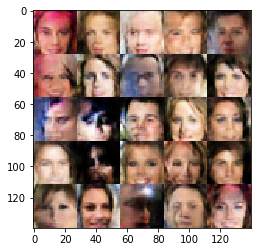

Epoch 1/1... Discriminator Loss: 1.8036... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 2.1899... Generator Loss: 0.2152
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7840


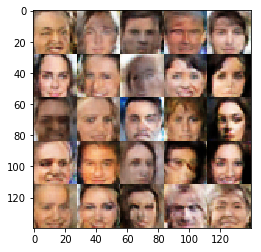

Epoch 1/1... Discriminator Loss: 2.1653... Generator Loss: 0.2013
Epoch 1/1... Discriminator Loss: 1.8989... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6181


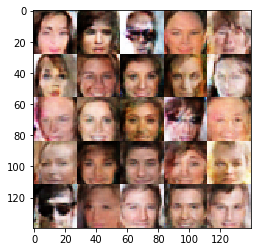

Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.6666... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 2.0589... Generator Loss: 0.2576
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.3829


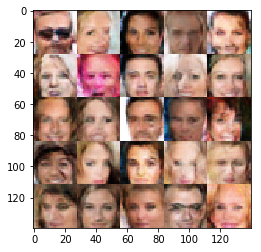

Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7931


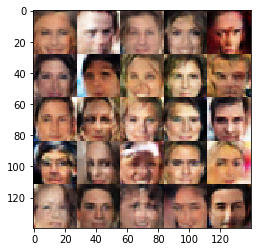

Epoch 1/1... Discriminator Loss: 2.1728... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.8670... Generator Loss: 0.3118
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.4059


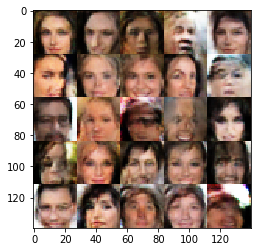

Epoch 1/1... Discriminator Loss: 1.8563... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.8725... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5630


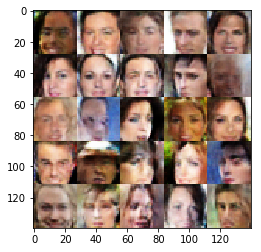

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.7960... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 2.0144... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5094


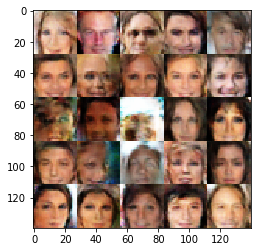

Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.7948... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.2157


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 2e-4
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.